<a href="https://colab.research.google.com/github/Yohk2291/MachineLearning/blob/master/image_classification/1_1_imagenet_vgg16_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Yohk2291/MachineLearning.git
%cd MachineLearning/
%cd image_classification/

Cloning into 'MachineLearning'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.
/content/MachineLearning/MachineLearning/image_classification/MachineLearning
/content/MachineLearning/MachineLearning/image_classification/MachineLearning/image_classification


In [0]:
import os
import urllib.request
import zipfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [0]:
import numpy as np
import json 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms


In [0]:
print("PyTorch Version", torch.__version__)
print("Torchvision Version", torchvision.__version__)

PyTorch Version 1.1.0
Torchvision Version 0.3.0


## 学習済みモデルをロード(VGG-16)

In [0]:
use_pretrained = True #学習済みパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval() #推論モード

print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## 入力画像の前処理クラス

In [0]:
# 画像サイズのリサイズ(224, 224)と色情報の標準化
class BaseTransform():
  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([
        transforms.Resize(resize), # 短辺の長さがresizeの大きさになる
        transforms.CenterCrop(resize), # 画像の中心をresize * resizeで切り取る
        transforms.ToTensor(), # テンソルに変換
        transforms.Normalize(mean, std) # 標準化
        ])
    
  def __call__(self, img):
    return self.base_transform(img)

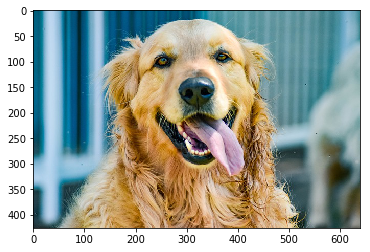

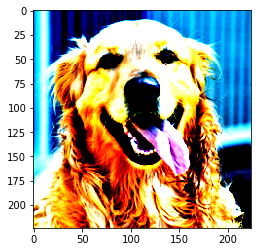

In [0]:
# 上記クラスの動作確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

# (C, H, W) -> (H, W, C)に変換
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
# 0-1に値を制限
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

## 出力結果からラベルを予測する後処理クラスを作成

In [0]:
# ILSVRCのデータ情報をロードし、辞書型変数を生成
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [0]:
class ILSVRCPredictor():

  def __init__(self, class_index):
    self.class_index = class_index

  def predict_max(self, out):
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name

In [0]:
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

predictor = ILSVRCPredictor(ILSVRC_class_index)

image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0) # ミニバッチの次元を追加(B, C, H, W)

out = net(inputs)
result = predictor.predict_max(out)

print("入力画像の予測結果:", result)

入力画像の予測結果: golden_retriever
